In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# Part 1: Outcomes from No-regret Learning in Games

## Set Up and Algorithm Definition

In [350]:
class EWAlg:
    def __init__(self, epsilon, k, h, myBids, myValue):
        self.weights = np.ones(k)
        self.payoffs = np.zeros(k)
        self.h = h
        self.k = k
        self.epsilon = epsilon
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myValue = myValue
        self.myBids = myBids
        self.myTotalValue = 0

    def getBids(self):
        return self.myBids

    def getValue(self):
        return self.myValue

    def getTotalValue(self):
        return self.myTotalValue

    def getAction(self):
        j = np.random.choice(self.k, 1, p = self.probs)
        return self.myBids[j.item()]
    
    def update(self, payoffs):
        for j in range(len(payoffs)):
            curPayoff = payoffs[j]
            self.payoffs[j] = self.payoffs[j] + curPayoff
            newWeight = (1+self.epsilon)**(self.payoffs[j]/self.h)
            self.weights[j] = newWeight
        self.sumWeights = np.sum(self.weights)
        if(self.epsilon > 1):
            self.weights = self.weights/self.sumWeights
            self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        return

    def generatePayoffs(self, bidToBeat, winningBid, meWin):
        if meWin:
            self.myTotalValue += self.myValue - winningBid
        payoffs = np.zeros(self.k)
        for count, bid in enumerate(self.myBids):
            if bid >= bidToBeat:
                payoffs[count] = self.myValue - bid
            else:
                payoffs[count] = 0
        return payoffs
    
    def reset(self):
        self.weights = np.ones(self.k)
        self.payoffs = np.zeros(self.k)
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myTotalValue = 0


In [351]:
class FirstPriceReserve:
    # bidders have to be ordered the same way every time
    # reserve given as a raw value
    def __init__(self, numBidders, reserve = 0):
        self.numBidders = numBidders
        self.totalPayoffs = np.zeros(self.numBidders)
        self.reserve = reserve
        
    def generate(self, bids):
        # set winning bid to reserve price
        winningBid = self.reserve
        winner = -1
        tiedBidders = []
        tied = False
        generatedBids = bids
        generatedBids.append(self.reserve)
        # check bids of all bidders
        for count, bid in enumerate(bids):
            if bid > winningBid:
                winningBid = bid
                winner = count
            elif (bid == winningBid) and (winner != -1):
                tiedBidders.append(count)
                tied = True
        if tied : winner = random.choice(tiedBidders)
        return [generatedBids, winningBid, winner]

In [362]:

def setUpPlayers() :
    # set up our players
    players = []
    for count in range(numPlayers):
    # pick a distribution and numPlayers values from it
        playerValue = random.uniform(min,h)
        # create possible bids using geometric discretization
        playerBids = []
        for j in range(k):
            playerBids.append(playerValue - ((1 + stepSize)**(-j))*playerValue)
        # create player
        player = EWAlg(epsilons[count], k, playerValue, playerBids, playerValue )
        players.append(player)
    return players

def conductAuction(players, auction, n = 100):
    # print("WE ARE IN conductAuction")
    # do the action n times
    allBidsCA = []
    allWinners = []
    for i in range(n):
        # print("round", i)
        bids = []
        # generate bids
        for count, player in enumerate(players):
            bids.append(player.getAction())
        # print("the bids are", bids)
        currbids = bids.copy()
        
        
        # conduct auction
        # roundBids, winningBid, winner = auction.generate(bids)
        results = auction.generate(currbids) #<-- somehow an extra 0 is getting added to the list
        roundBids = results[0]
        #print("this rounds bids were: " ,roundBids)
        winningBid = results[1]
        #print("winning bid: " ,winningBid)
        winner = results[2]
        allWinners.append(winner)
        # update payoffs
        for count, player in enumerate(players):
            oppositionBids = roundBids.copy()
            # print("opposition bids: ", oppositionBids)
            oppositionBids[count] = 0
            bidToBeat = max(oppositionBids)
            # print("bid to beat is: ", bidToBeat)
            if count == winner:
                payoffs = player.generatePayoffs(bidToBeat, winningBid, True)
            else:
                payoffs = player.generatePayoffs(bidToBeat, winningBid, False)
            player.update(payoffs)
            #print(payoffs)
        # print("allBidsCA is now ", allBidsCA)
        # print("appending bids to allBidsCA now")
        # print("the bids are", bids)
        allBidsCA.append(bids)
        # print("at the end of the round, allBidsCA is now", allBidsCA)
    # print("final allBids is ", allBidsCA)
    return allBidsCA, allWinners

In [363]:
# set hyperparameters
numPlayers = 2
n = 500
epsilons = [10,0.088]
h = 10
min = 1
k = 50
stepSize = np.log(h) / k

MCBound = 500
reserveFrac = 0 #between 0 and 1
reserveValue = reserveFrac * (h + min)


# set up players
players = setUpPlayers()
# set up the auction 
auction = FirstPriceReserve(2, reserveValue)


values = []
totalWinnings = [[], []]
possibleBids = []
for player in players:
    values.append(player.getValue())
    possibleBids.append(player.getBids())

MCBids = []
MCWinners = []
for i in range(MCBound):
    # conduct auction
    allBids, allWinners = conductAuction(players, auction, n)
    # print("all bids = ", allBids)
    for count, player in enumerate(players):
        totalWinnings[count].append(player.getTotalValue())
        # print(player.getTotalValue())
    # reset players -> they keep same learning rate and values
    for player in players:
        player.reset()
    MCBids.append(allBids)
    MCWinners.append(allWinners)
avgBids = np.array(MCBids)
avgBids = np.mean(avgBids, 0)
totalWinnings = np.mean(np.array(totalWinnings), 1)

print(values)
print(totalWinnings)
#print(avgBids)
# print(MCBids)

[3.695209409442322, 3.144780496441475]
[427.01496986  15.77122298]


In [365]:
for player in players:
    print(player.myBids)

[0.0, 0.1626790355877259, 0.3181962392770674, 0.46686690575830525, 0.6089924490912986, 0.7448610137906284, 0.8747480590081409, 0.9989169169972558, 1.1176193269912775, 1.2310959455780726, 1.339576834605865, 1.443281927609311, 1.542421475701493, 1.6371964738358216, 1.7277990683020594, 1.814412946282609, 1.8972137082588578, 1.9763692240225899, 2.052039973014244, 2.124379369678015, 2.193534074493419, 2.259644291313913, 2.322844051615388, 2.383261486230814, 2.4410190851219626, 2.4962339457148524, 2.549018010302404, 2.599478292995603, 2.647717096683299, 2.6938322204404965, 2.7379171578056427, 2.780061286328892, 2.82035004877564, 2.858865126352699, 2.89568460430831, 2.930883130241728, 2.964532065443339, 2.9966996295721318, 3.0274510389638465, 3.056848638850199, 3.084952029757248, 3.1118181883391625, 3.1375015828923636, 3.1620542837842374, 3.1855260690203, 3.207964525163845, 3.229415143812664, 3.249921413828458, 3.2695249095059022, 3.288265374860138]
[0.0, 0.1384467838247354, 0.270798543855884

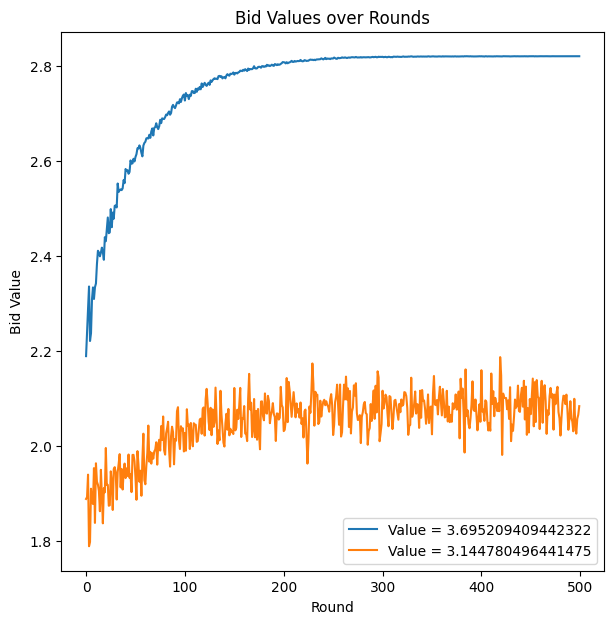

In [364]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)

newBids = [[], []]
for i in range(n):
    newBids[0].append(avgBids[i][0])
    newBids[1].append(avgBids[i][1])

plt.plot(np.arange(n), newBids[0], label = "Value = " + str(values[0]))
plt.plot(np.arange(n), newBids[1], label = "Value = " + str(values[1]))
plt.title('Bid Values over Rounds')
plt.xlabel('Round')
plt.ylabel('Bid Value')
plt.legend()
plt.show()
# f.savefig('RegretvRoundAf.png')

In [271]:
def MonteCarlo(numTrials, payoffGenerator, epsilon, k, h, n):
    avgFinalPayoff = 0
    avgRegretPerRound = [[] for i in range(numTrials)]
    for trial in range(numTrials):
        alg = EWAlg(epsilon, k, h)
        finalPayoff = 0
        actionPayoffs = np.zeros(k)
        generator = payoffGenerator(k)
        regretPerRound = np.zeros(n)
        for i in range(n):
            payoffs = generator.generate()
            j = alg.getAction()
            myPayoff = payoffs[j]
            actionPayoffs += payoffs
            alg.update(payoffs)
            finalPayoff += myPayoff
            OPT = max(actionPayoffs)
            regret = (OPT - finalPayoff).item() / (i+1)
            regretPerRound[i] = regret
        avgFinalPayoff += finalPayoff
        avgRegretPerRound[trial] = regretPerRound
    return avgFinalPayoff/numTrials, np.mean(avgRegretPerRound, axis=0)

In [272]:
def MonteCarloTrackActions(numTrials, payoffGenerator, epsilon, k, h, n):
    avgFinalPayoff = 0
    avgRegretPerRound = [[] for i in range(numTrials)]
    actionTrial = []
    for trial in range(numTrials):
        alg = EWAlg(epsilon, k, h)
        finalPayoff = 0
        actionPayoffs = np.zeros(k)
        generator = payoffGenerator(k)
        regretPerRound = np.zeros(n)
        actions = np.zeros(n)
        for i in range(n):
            payoffs = generator.generate()
            j = alg.getAction()
            actions[i] = j
            myPayoff = payoffs[j]
            actionPayoffs += payoffs
            alg.update(payoffs)
            finalPayoff += myPayoff
            OPT = max(actionPayoffs)
            regret = (OPT - finalPayoff).item() / (i+1)
            regretPerRound[i] = regret
        actionTrial.append(actions)
        avgFinalPayoff += finalPayoff
        avgRegretPerRound[trial] = regretPerRound
    return avgFinalPayoff/numTrials, np.mean(avgRegretPerRound, axis=0), np.array(actionTrial)

## Manipulating a No-Regret Learner